# 1. Authenticate and Initialize Google Earth Engine

In [1]:
# Import earth engine
import ee
import geemap

import json
import pandas as pd

# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
  
# %matplotlib inline: only draw static images in the notebook
%matplotlib inline

# Authentication 
ee.Authenticate()

# Library initialization 
ee.Initialize();

Enter verification code: 4/1Adeu5BVw6YkPQ3x-wcVeDygCjbb118bMNT0UZdS5liZb_Ga2DDWpc-zj8M8

Successfully saved authorization token.


# 2. Load tree cover data and visualize Zambia forest coverage and loss

In [2]:
# Import 2022 tree cover image
gfc2022 = ee.Image("UMD/hansen/global_forest_change_2022_v1_10") 
# This is the latest version: https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2022_v1_10
# Resolution 30.92 meters

# Get country boundaries
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')


In [3]:
forest = gfc2022.select(['treecover2000'])
loss = gfc2022.select(['loss'])
lossYear = gfc2022.select(['lossyear']) #Year of gross forest cover loss event. Forest loss during the study period, defined as a stand-replacement disturbance, or a change from a forest to non-forest state. Encoded as either 0 (no loss) or else a value in the range 1-22, representing loss detected primarily in the year 2001-2022, respectively.


# visualization setting
vis = {
'min': 0, 
'max': 100, 
'palette': ['#000000', '#005500', '#00AB00', '#00FF00']
}

Map = geemap.Map()

# Add layers: satellite image
Map.addLayer(gfc2022, {'bands': ['last_b50', 'last_b40', 'last_b30']}, 'false color') # Here's an image that uses 3 bands, Landsat bands 5, 4, and 3 for 2022. This band combination shows healthy vegetation as green and soil as mauve::

# Optional: Draw boundaries for Zambia
# Select boundary of Zambia
# kh = countries.filter(ee.Filter.eq("country_na", "Zambia"))
# Zambia_bd = kh.geometry()
# country_vis_params = {'color': '#0000FF', 'fillColor': '#0000FF'}
# Map.addLayer(Zambia_bd, country_vis_params, opacity = 0.3);

# Draw boundaries for luangwa project area
luangwa_eeobject = geemap.geojson_to_ee("C:/Users/Amanda/Desktop/jobs/job_prep_materials/Applying/Renoster/Take_Home_Assignment_Forest_Carbon_Scientist/luangwa_project_area.geojson") # # To convert a GeoJSON file to Earth Engine object and add it to the Map
luangwa_vis_params = {'color': '#00FF00', 'fillColor': '#00FF00'}
Map.addLayer(luangwa_eeobject,luangwa_vis_params,opacity = 0.4 )

# Draw boundaries for reference area
ref_eeobject = geemap.geojson_to_ee("C:/Users/Amanda/Desktop/jobs/job_prep_materials/Applying/Renoster/Take_Home_Assignment_Forest_Carbon_Scientist/luangwa_reference_region.geojson") # # To convert a GeoJSON file to Earth Engine object and add it to the Map
ref_polygon = ref_eeobject.geometry()
ref_vis_params = {'color': '#FFA500', 'fillColor': '#FFA500'} # orange color
Map.addLayer(ref_polygon,ref_vis_params,opacity = 0.4 )

# add forest loss data on top
Map.addLayer(loss.updateMask(loss), {'palette': ['#FF0000']} , 'Loss 2001-2022') #tree loss from 2001 - 2022


In [4]:
Map.centerObject(luangwa_eeobject, zoom =6)

Map

# showing here:
# Bright red pixels = forest loss from 2001- 2022
# Areial image background: This band combination shows healthy vegetation as green and soil as mauve in 2022
# Translucent green polygons = Luangwa project area 
# Translucent orange polygones = reference area 

Map(center=[-14.06445415939777, 30.832317656164694], controls=(WidgetControl(options=['position', 'transparent…

# 3. Calculating yearly forest loss

In [5]:
# Loss by year in the project area
lossImage = gfc2022.select(['loss'])
lossAreaImage = lossImage.multiply(ee.Image.pixelArea())

lossByYear = lossAreaImage.addBands(lossYear).reduceRegion(
    reducer=ee.Reducer.sum().group(**{
        'groupField': 1,
        'groupName': 'lossyear'
    }),
    geometry=luangwa_eeobject,
    scale=30.92, # in meters
    maxPixels=1e20
)

type(lossByYear)

# Convert ee.Dictionary to Python dictionary
python_dict = lossByYear.getInfo() # note that the sum is in the unit of sq meters

# Extract the data from the 'groups' key
data_list = python_dict['groups']

# Create a pandas DataFrame
luangwa_df = pd.DataFrame(data_list)

# reformat the year by adding 2000 to the number
luangwa_df['lossyear'] = luangwa_df['lossyear'] + 2000

# reformat the sum, convert from sq meters to hecters
luangwa_df['sum'] = luangwa_df['sum']*0.0001
luangwa_df.rename(columns={"sum": "Loss_area_hectares_project"}, inplace=True)

# Display the DataFrame
luangwa_df

,lossyear,Loss_area_hectares_project
0,2001,92.305814
1,2002,103.843345
2,2003,56.224861
3,2004,27.101448
4,2005,179.166247
5,2006,23.783643
6,2007,72.840135
7,2008,50.681362
8,2009,40.260751
9,2010,49.429575


In [6]:
# Loss by year in the reference area
lossImage_ref = gfc2022.select(['loss'])
lossAreaImage_ref = lossImage_ref.multiply(ee.Image.pixelArea())

lossByYear_ref = lossAreaImage_ref.addBands(lossYear).reduceRegion(
    reducer=ee.Reducer.sum().group(**{
        'groupField': 1,
        'groupName': 'lossyear'
    }),
    geometry=ref_eeobject,
    scale=30.92, # in meters
    maxPixels=1e20
)

type(lossByYear_ref)

# Convert ee.Dictionary to Python dictionary
ref_python_dict = lossByYear_ref.getInfo() # note that the sum is in the unit of sq meters

# Extract the data from the 'groups' key
ref_data_list = ref_python_dict['groups']

# Create a pandas DataFrame
ref_df = pd.DataFrame(ref_data_list)

# reformat the year by adding 2000 to the number
ref_df['lossyear'] = ref_df['lossyear'] + 2000

# reformat the sum, convert from sq meters to hecters
ref_df['sum'] = ref_df['sum']*0.0001
ref_df.rename(columns={"sum": "Loss_area_hectares_ref"}, inplace=True)

# Display the DataFrame
ref_df

,lossyear,Loss_area_hectares_ref
0,2001,666.522608
1,2002,1895.562302
2,2003,2313.518745
3,2004,3486.520643
4,2005,3269.264752
5,2006,2268.408417
6,2007,2300.644634
7,2008,5179.354924
8,2009,3336.260517
9,2010,1092.881968


In [7]:
# Join luangwa_df and ref_df
luangwa_ref_df = pd.merge(luangwa_df, ref_df, on='lossyear')

# calculate accumulative loss in ha
luangwa_ref_df['loss_project_cumsum'] = luangwa_ref_df['Loss_area_hectares_project'].rolling(min_periods=1, window=22).sum()

# calculate accumulative loss in ha
luangwa_ref_df['loss_ref_cumsum'] = luangwa_ref_df['Loss_area_hectares_ref'].rolling(min_periods=1, window=22).sum()

luangwa_ref_df


,lossyear,Loss_area_hectares_project,Loss_area_hectares_ref,loss_project_cumsum,loss_ref_cumsum
0,2001,92.305814,666.522608,92.305814,666.522608
1,2002,103.843345,1895.562302,196.149159,2562.084909
2,2003,56.224861,2313.518745,252.374020,4875.603655
3,2004,27.101448,3486.520643,279.475468,8362.124298
4,2005,179.166247,3269.264752,458.641715,11631.389050
5,2006,23.783643,2268.408417,482.425358,13899.797467
6,2007,72.840135,2300.644634,555.265494,16200.442101
7,2008,50.681362,5179.354924,605.946855,21379.797025
8,2009,40.260751,3336.260517,646.207606,24716.057542
9,2010,49.429575,1092.881968,695.637181,25808.939510


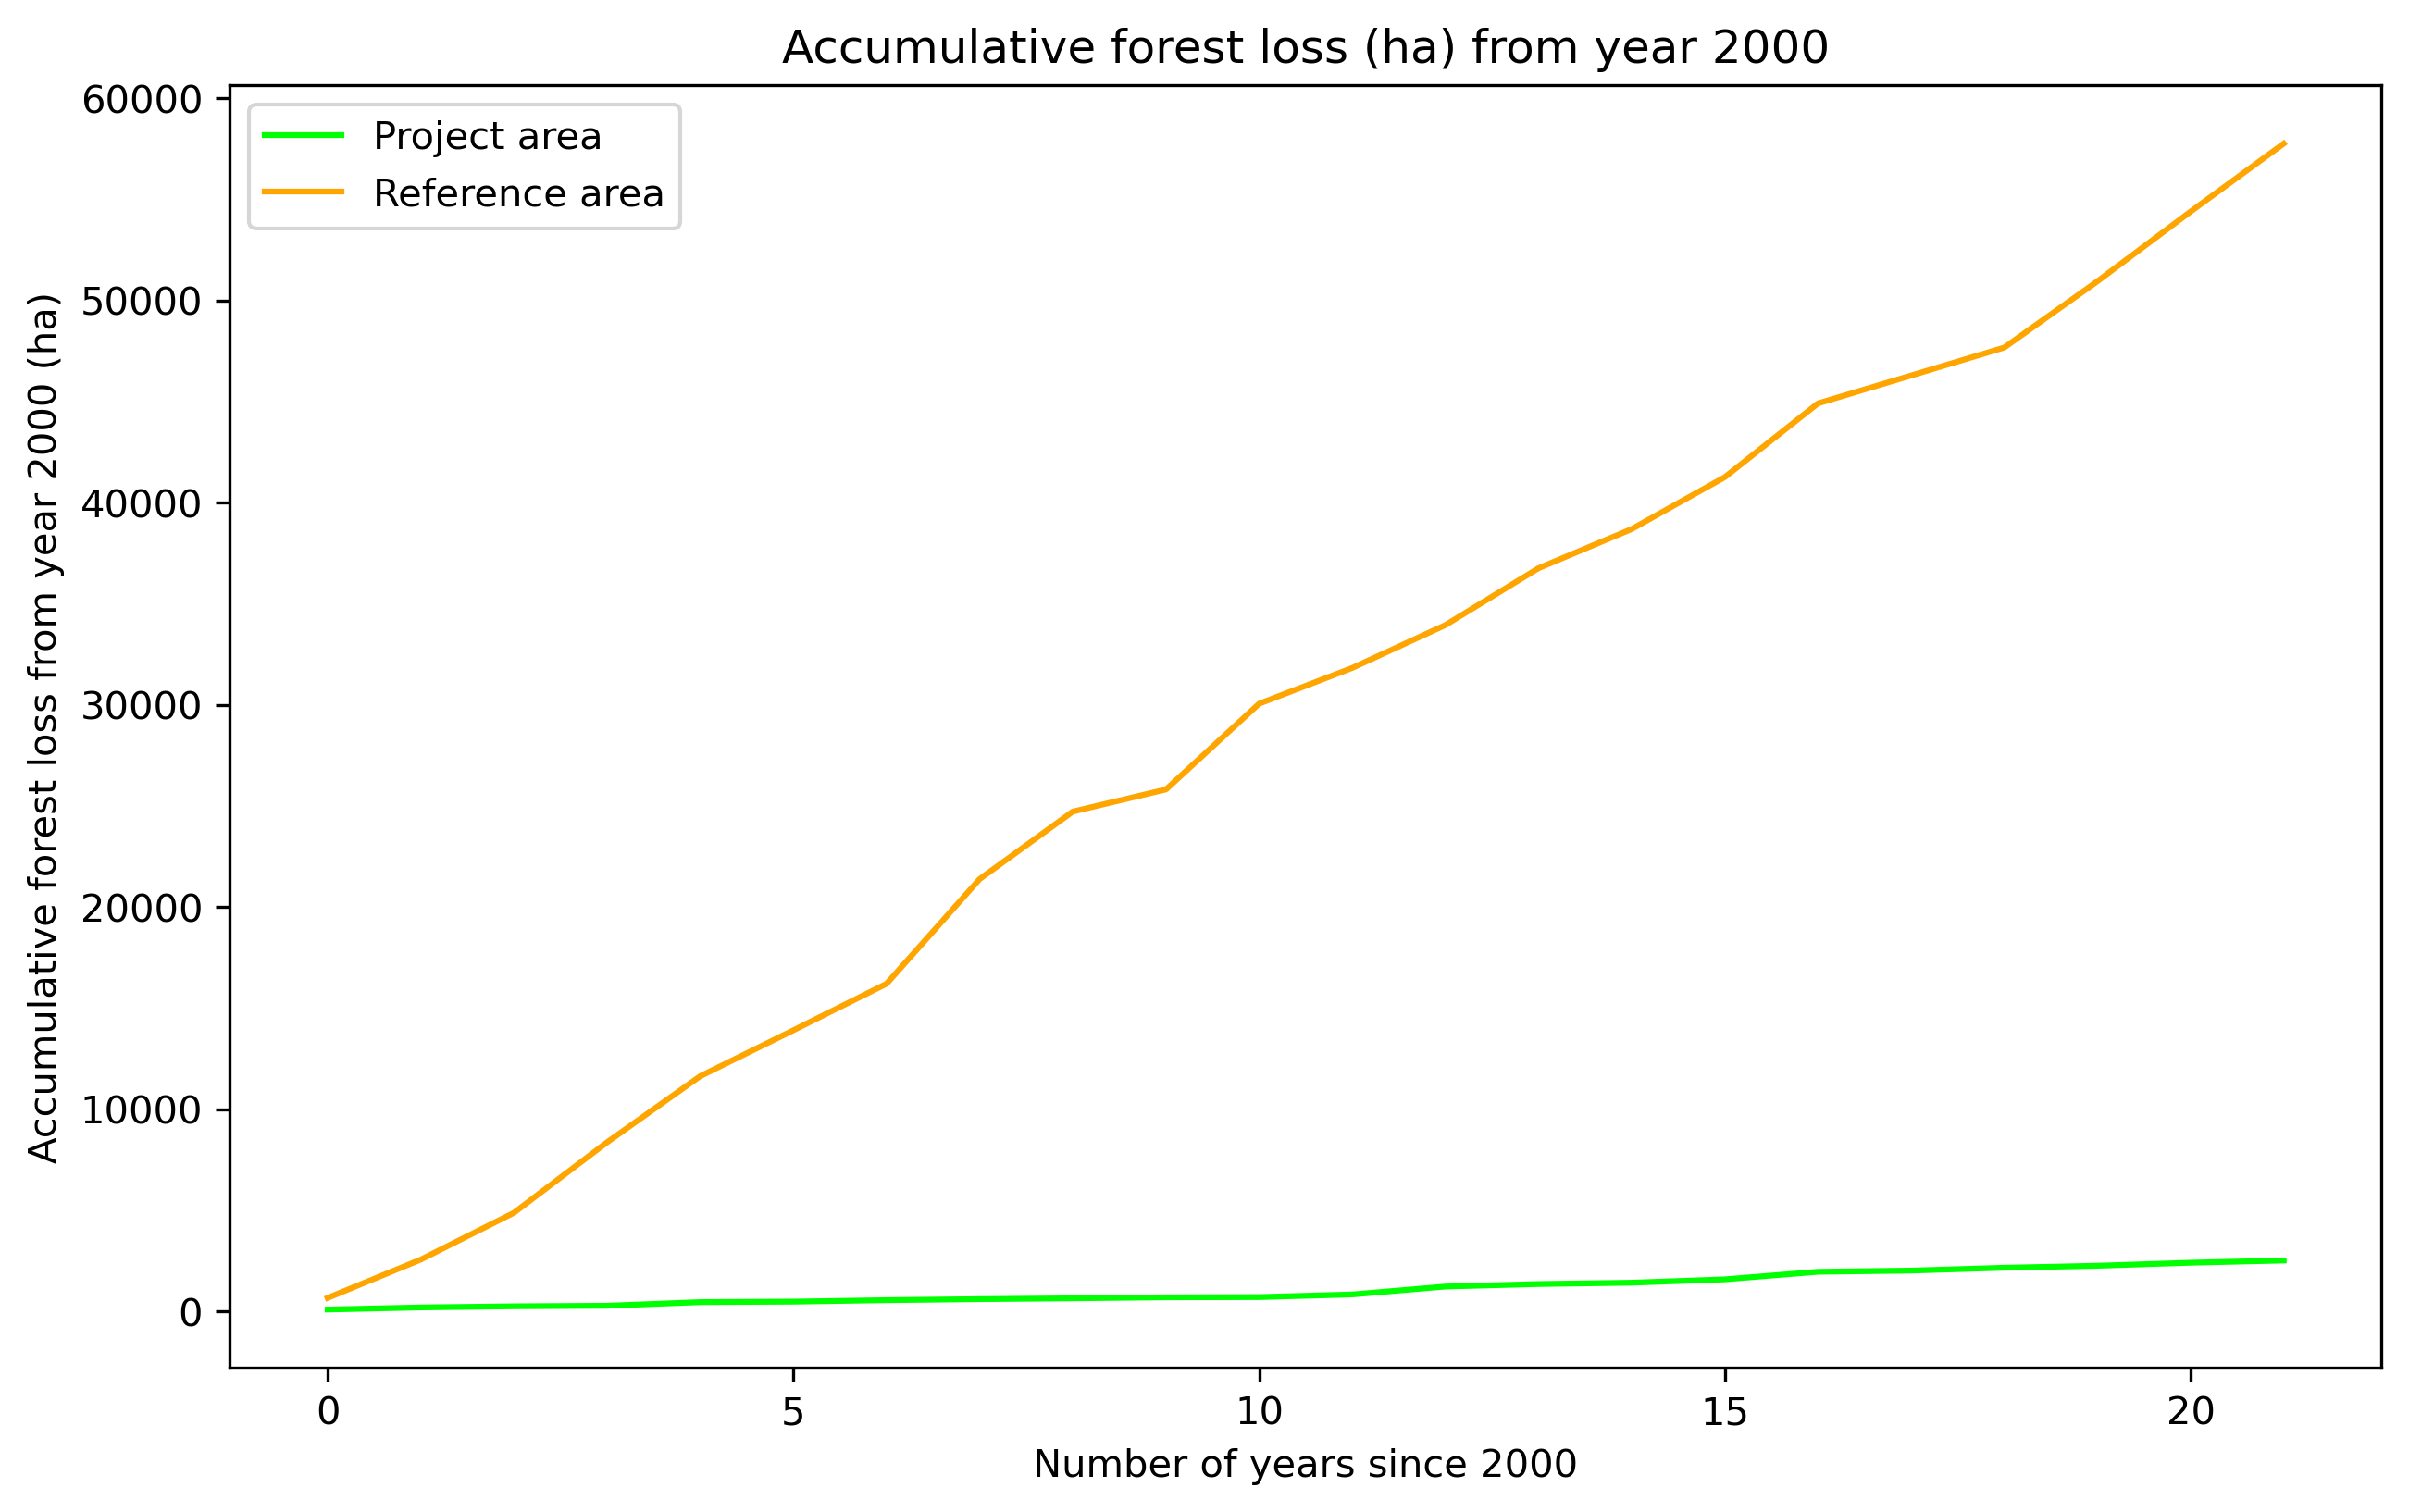

In [8]:
# Plotting the accumulative loss area
    
# to set the plot size
plt.figure(figsize=(10, 6), dpi=300)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
luangwa_ref_df['loss_project_cumsum'].plot(label='Project area', color='#00FF00') # green color for projecr area
luangwa_ref_df['loss_ref_cumsum'].plot(label='Reference area', color='#FFA500') # orange color for projecr area

# adding title to the plot
plt.title('Accumulative forest loss (ha) from year 2000')
  
# adding Label to the x-axis
plt.xlabel('Number of years since 2000')
  
# adding Label to the y-axis
plt.ylabel('Accumulative forest loss from year 2000 (ha)')

# adding legend to the curve
plt.legend()
